In [ ]:
# Install required libraries
!pip install -q tensorflow scikit-learn matplotlib

In [ ]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Install necessary libraries
!pip install -q kaggle

In [ ]:
# Upload Kaggle API key (Upload your 'kaggle.json' manually)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atgam22","key":"1ca655584acdb5126096c7a8cc65f406"}'}

In [ ]:
# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Download the dataset
!kaggle datasets download -d anaselmasry/breast-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/anaselmasry/breast-cancer-dataset
License(s): copyright-authors


In [ ]:
# Unzip the dataset
import zipfile
import os

zip_file = "breast-cancer-dataset.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("breast_cancer_data")

In [ ]:
# Set dataset paths
import os
data_dir = "breast_cancer_data/BreaKHis_Total_dataset"
malignant_dir = os.path.join(data_dir, "malignant")
benign_dir = os.path.join(data_dir, "benign")

In [ ]:
# Define image size for ResNet50
IMG_SIZE=(128, 128)
BATCH_SIZE = 16

In [ ]:
# Load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=IMG_SIZE)  # Resize to 224x224
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)  # Normalize for ResNet50
        images.append(img_array)
        labels.append(label)
    return images, labels

In [ ]:
# Load malignant and benign images
malignant_images, malignant_labels = load_images_from_folder(malignant_dir, label=1)
benign_images, benign_labels = load_images_from_folder(benign_dir, label=0)


In [ ]:
# Combine data
X = np.array(malignant_images + benign_images)
y = np.array(malignant_labels + benign_labels)

In [ ]:
# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


FEATURE EXTRACTION USING RESNET50

In [ ]:
resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")  # Global Average Pooling

# Extract features
X_train_features = resnet_model.predict(X_train)
X_test_features = resnet_model.predict(X_test)

# Standardize features for ML models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


2. TRAINING TRADITIONAL ML MODELS

In [ ]:
#  Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

#  SVM
svm = SVC(kernel="linear")
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

#  Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

3. TRAINING A CNN MODEL

In [ ]:
# Import the ModelCheckpoint class
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the directory to save the model
MODEL_DIR = 'saved_models'  # or any other path you prefer
os.makedirs(MODEL_DIR, exist_ok=True) # create the directory if it doesn't exist

cnn_model = Sequential([
    tf.keras.applications.ResNet50(include_top=False, weights="imagenet", pooling="avg"),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # Binary classification
])

cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    f'{MODEL_DIR}/best_cnn.keras',  # Consistent filename
    save_best_only=True,
    monitor='val_accuracy'
)

# Pass the callback to the fit method
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Evaluate CNN
y_pred_cnn = (cnn_model.predict(X_test) > 0.5).astype("int32")

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 110s 270ms/step - accuracy: 0.7911 - loss: 0.6113 - val_accuracy: 0.6821 - val_loss: 1.9789
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.8783 - loss: 0.3211 - val_accuracy: 0.7425 - val_loss: 6.9250
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - accuracy: 0.8937 - loss: 0.2731 - val_accuracy: 0.9184 - val_loss: 0.2324
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 121ms/step - accuracy: 0.9210 - loss: 0.1976 - val_accuracy: 0.7033 - val_loss: 0.6824
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.9352 - loss: 0.1708 - val_accuracy: 0.8414 - val_loss: 0.4876
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.9363 - loss: 0.1591 - val_accuracy: 0.8041 - val_loss: 1.2549
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.9551 - loss: 0.1242 - val_accuracy: 0.5369 - val_loss: 1.9978
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - accuracy: 0.9460 - loss: 

4. EVALUATION & COMPARISON


🔹 Logistic Regression Accuracy: 0.9030
Confusion Matrix:
 [[429  67]
 [ 84 977]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       496
           1       0.94      0.92      0.93      1061

    accuracy                           0.90      1557
   macro avg       0.89      0.89      0.89      1557
weighted avg       0.90      0.90      0.90      1557



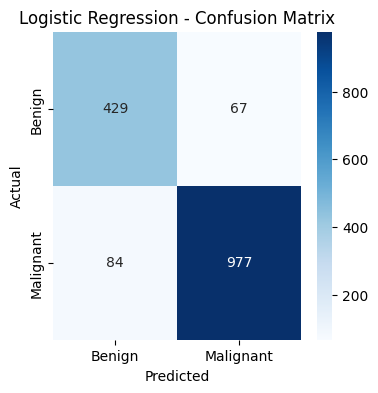


🔹 SVM Accuracy: 0.8838
Confusion Matrix:
 [[414  82]
 [ 99 962]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       496
           1       0.92      0.91      0.91      1061

    accuracy                           0.88      1557
   macro avg       0.86      0.87      0.87      1557
weighted avg       0.89      0.88      0.88      1557



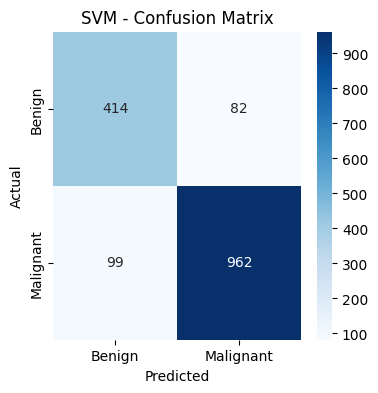


🔹 Random Forest Accuracy: 0.8664
Confusion Matrix:
 [[ 325  171]
 [  37 1024]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.66      0.76       496
           1       0.86      0.97      0.91      1061

    accuracy                           0.87      1557
   macro avg       0.88      0.81      0.83      1557
weighted avg       0.87      0.87      0.86      1557



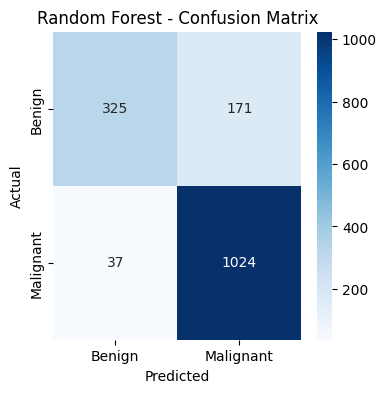


🔹 CNN Accuracy: 0.7771
Confusion Matrix:
 [[478  18]
 [329 732]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.96      0.73       496
           1       0.98      0.69      0.81      1061

    accuracy                           0.78      1557
   macro avg       0.78      0.83      0.77      1557
weighted avg       0.85      0.78      0.78      1557



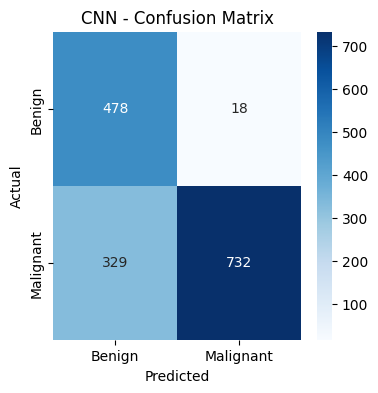

In [ ]:
def evaluate_model(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n🔹 {model_name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# Evaluate all models
evaluate_model("Logistic Regression", y_test, y_pred_logreg)
evaluate_model("SVM", y_test, y_pred_svm)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("CNN", y_test, y_pred_cnn)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:32:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 XGBoost Accuracy: 0.8985
Confusion Matrix:
 [[ 389  107]
 [  51 1010]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83       496
           1       0.90      0.95      0.93      1061

    accuracy                           0.90      1557
   macro avg       0.89      0.87      0.88      1557
weighted avg       0.90      0.90      0.90      1557



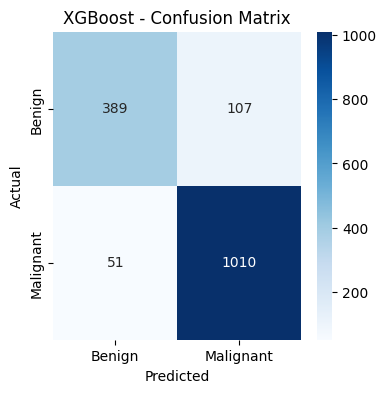

In [ ]:
# Install XGBoost if not installed
!pip install -q xgboost

from xgboost import XGBClassifier

#  Train XGBoost Model
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train_scaled, y_train)

#  Predict with XGBoost
y_pred_xgb = xgb.predict(X_test_scaled)

#  Evaluate XGBoost Model
evaluate_model("XGBoost", y_test, y_pred_xgb)


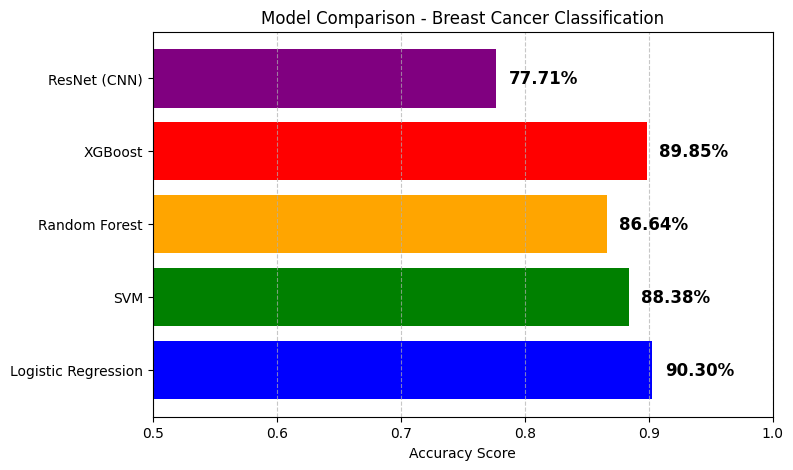

In [ ]:
import matplotlib.pyplot as plt

# Store accuracy scores
model_names = ["Logistic Regression", "SVM", "Random Forest", "XGBoost", "ResNet (CNN)"]
accuracies = [
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_cnn)
]

# Plot Bar Chart
plt.figure(figsize=(8, 5))
plt.barh(model_names, accuracies, color=["blue", "green", "orange", "red", "purple"])
plt.xlabel("Accuracy Score")
plt.title("Model Comparison - Breast Cancer Classification")
plt.xlim(0.5, 1)  # Accuracy range from 50% to 100%
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show accuracy values on bars
for index, value in enumerate(accuracies):
    plt.text(value + 0.01, index, f"{value:.2%}", va="center", fontsize=12, fontweight="bold")

plt.show()


In [ ]:
import joblib
joblib.dump(logreg, 'logistic_regression_model.pkl')
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
cnn_model.save('cnn_model.h5')  # Replace `cnn_model` with your model variable
resnet_model.save('resnet_model.h5')  # Replace with your actual ResNet model variable


In [ ]:
# === For ML models ===
import joblib

logreg_model = joblib.load('logistic_regression_model.pkl')
svm_model = joblib.load('svm_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
xgb_model = joblib.load('xgboost_model.pkl')

# === For DL models ===
from tensorflow.keras.models import load_model

cnn_model = load_model('cnn_model.h5')
resnet_model = load_model('resnet_model.h5')


FileNotFoundError: [Errno 2] No such file or directory: '/content/logistic_regression_model.pkl'

In [ ]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
cnn_model = load_model('cnn_model.h5')

# Pick an image from your dataset folder
img_path = os.path.join('dataset', 'malignant', 'example.jpg')  # Change folder & filename as needed
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
cnn_model = load_model('cnn_model.h5')

# Pick an image from your dataset folder
img_path = os.path.join('dataset', 'malignant', 'example.jpg')  # Change folder & filename as needed

# Load and preprocess the image
img = image.load_img('/content/malignant.png', target_size=(224, 224))  # Match your model’s expected input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict
prediction = cnn_model.predict(img_array)

# Show result
if prediction[0][0] > 0.5:
    print(f"Prediction for {img_path}: Malignant (Cancerous)")
else:
    print(f"Prediction for {img_path}: Benign (Non-cancerous)")
img_array = img_array / 255.0




1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction for dataset/malignant/example.jpg: Malignant (Cancerous)
